In [1]:
VIDEO_FRAMERATE = 30 #nr of frames per second
#it takes my pc 3 min 15 s with framerate 0.5. For 25 fps, estimated is 2 h and 45 mins
PATH_TO_VIDEO = '2022-06-14_16-38-43_S04_eye-tracking-video-world_frame.mp4'
PATH_TO_INFO_AND_CROSS = "2022-06-14_16-38-43_streamLog_actionNet-wearables_S04.hdf5"
VIDEO_ID = "S0401"
FRAMES_SAVE_PATH = "actionNet/" + VIDEO_ID
CALIBRATION_SHIFT = 14*60 + 21 # the first part of the video is usless
PIKLE_PATH = "actionNet/S0401"

VIDEO_SAMPLING_RATE = 1/VIDEO_FRAMERATE
import h5py, numpy as np
import cv2
import os
from datetime import datetime
import pandas as pd
import torch
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
import torchaudio.transforms as T


## Video transformation into frames

In [6]:
directory = FRAMES_SAVE_PATH

# Check if the directory exists
if not os.path.exists(directory):
    # If it doesn't exist, create it
    os.makedirs(directory)

In [ ]:
#you need to have ffmpeg exe somewhere
%%bash

FFMPEG_PATH="C:/Users/NonAv/Desktop/ffmpeg-6.0-essentials_build/bin/ffmpeg.exe"
PATH_TO_VIDEO="./2022-06-14_16-38-43_S04_eye-tracking-video-world_frame.mp4"
FRAMES_SAVE_PATH="actionNet/S04_01"

$FFMPEG_PATH -ss 00:14:21 -i $PATH_TO_VIDEO $FRAMES_SAVE_PATH/img_%010d.jpg -vf "scale=456:256" 

In [19]:
vidcap = cv2.VideoCapture(PATH_TO_VIDEO)
video_fps = vidcap.get(cv2.CAP_PROP_FPS)
framecount = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
"number of frames expected: " + str(round(framecount - video_fps* CALIBRATION_SHIFT))

'number of frames expected: 83225'

In [23]:
import os
files = os.listdir(FRAMES_SAVE_PATH)
i = 1

for file in files:
    new_file_num = int(file.split("_")[1].split(".")[0])-1
    new_file_name = "img_"+f'{new_file_num:010d}'+".jpg"
    os.rename(os.path.join(FRAMES_SAVE_PATH, file), os.path.join(FRAMES_SAVE_PATH,new_file_name))

    #i = i+1

## EMG

In [6]:
# Replace with your path to one of the subjects from Action-Net
emg_annotations = pd.read_pickle("./actionNet/raw.pkl")

sample_no = 3
signal = torch.from_numpy(emg_annotations.iloc[sample_no].myo_left_readings).float()
title = emg_annotations.iloc[sample_no].description


FUNCTIONS FOR EMG WAVE

In [7]:

def lowpass_filter(data, cutoff, Fs, order=5):
  nyq = 0.5 * Fs
  normal_cutoff = cutoff / nyq
  b, a = butter(order, normal_cutoff, btype='low', analog=False)
  y = lfilter(b, a, data.T).T
  return y

def preprocess_single(readings, t):
    Fs = (t.size - 1) / (t[-1] - t[0])
    preprocessed = np.array(readings)
    preprocessed = abs(preprocessed)
    preprocessed = lowpass_filter(preprocessed, 5, Fs)
    min = preprocessed.min().min()
    max = preprocessed.max().max()
    preprocessed = (preprocessed - min)/(max-min)
    return preprocessed.sum(axis=1)

def pad_and_fuse(prep1, prep2):
  l1, l2 = len(prep1), len(prep2)
  if l1 == l2: return prep1 + prep2
  min_len, max_len, to_be_padded, target = (l1, l2, prep1, prep2) if l1 < l2 else (l2, l1, prep2, prep1)
  to_be_padded = np.append(to_be_padded,([0 for _ in range(max_len-min_len)]))
  return np.array([a + b for a,b in zip(to_be_padded, target)])

def zero_pad_or_trunk(arr, len_max):
   if len(arr)==len_max: return arr
   elif len(arr)<len_max: return np.hstack([arr, np.array([0 for _ in range(len_max - len(arr))])])
   else: return arr[0:len_max]
columns = emg_annotations.columns
preprocess = lambda emg_ann : pad_and_fuse(preprocess_single(emg_ann[columns.get_loc("myo_right_readings")], emg_ann[columns.get_loc("myo_right_timestamps")]), preprocess_single(emg_ann[columns.get_loc("myo_left_readings")], emg_ann[columns.get_loc("myo_left_timestamps")]))

preprocessed = emg_annotations.iloc[1:,:].apply(lambda row : preprocess(row) ,axis=1).reset_index(drop=True)
emg_readings_series = pd.Series(preprocessed)

FUNCTIONS FOR EMG SPEC

In [8]:
MAX_LEN_ARRS = 1000

In [9]:
# Sampling frequency is 160 Hz
# With 32 samples the frequency resolution after FFT is 160 / 32

n_fft = 32
win_length = None
hop_length = 4

spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    normalized=True
)


def compute_spectrogram(sx, dx):
    ten_sx = torch.from_numpy(sx).float()
    ten_dx = torch.from_numpy(dx).float()
    freq_signal_sx = np.array([spectrogram(ten_sx[:,i ]).numpy() for i in range(8)])
    freq_signal_dx = np.array(([spectrogram(ten_dx[:,i ]).numpy() for i in range(8)]))
    if(freq_signal_sx.shape != freq_signal_dx.shape):
        print(freq_signal_sx.shape)
        print(freq_signal_dx.shape)
    return np.vstack([freq_signal_sx, freq_signal_dx])

def zero_pad_or_trunk_spec(l, len_max):
    arr = np.array(l)
    if len(arr)==len_max: return arr
    elif len(arr)<len_max: return np.vstack([arr, np.array([[0 for j in range(8)] for _ in range(len_max - len(arr))])])
    else: return arr[0:len_max]

columns = emg_annotations.columns
get_specs = lambda emg_ann : compute_spectrogram(zero_pad_or_trunk_spec(emg_ann[columns.get_loc("myo_left_readings")],MAX_LEN_ARRS),zero_pad_or_trunk_spec(emg_ann[columns.get_loc("myo_right_readings")],MAX_LEN_ARRS))


In [10]:
padded = [zero_pad_or_trunk(l, 1000) for l in list(preprocessed)]

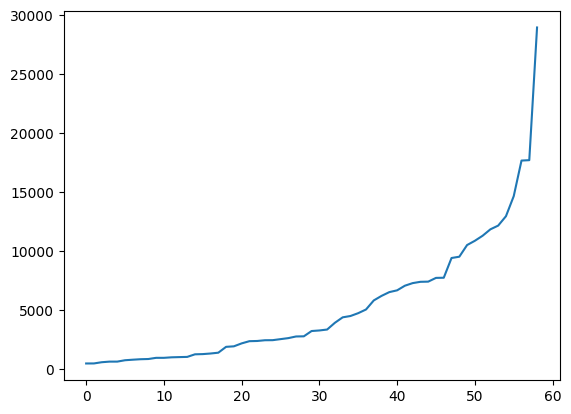

In [11]:
import matplotlib.pyplot as plt
plt.plot(sorted([len(l) for l in list(preprocessed)]))


In [12]:
sorted([len(l) for l in list(preprocessed)])[56]

17674

In [13]:
emg_readings_series = pd.Series(padded)

In [14]:
emg_readings_series.to_pickle(PIKLE_PATH + ".pkl", protocol=4)

## Labels and dataframe (records)

In [15]:



h5_file = h5py.File(PATH_TO_INFO_AND_CROSS)

device_name = 'experiment-activities'
stream_name = 'activities'

# Get the timestamped label data.
# As described in the HDF5 metadata, each row has entries for ['Activity', 'Start/Stop', 'Valid', 'Notes'].
activity_datas = h5_file[device_name][stream_name]['data']
activity_times_s = h5_file[device_name][stream_name]['time_s']
activity_times_s = np.squeeze(np.array(activity_times_s))  # squeeze (optional) converts from a list of single-element lists to a 1D list
# Convert to strings for convenience.
activity_datas = [[x.decode('utf-8') for x in datas] for datas in activity_datas]

# Combine start/stop rows to single activity entries with start/stop times.
#   Each row is either the start or stop of the label.
#   The notes and ratings fields are the same for the start/stop rows of the label, so only need to check one.
exclude_bad_labels = True # some activities may have been marked as 'Bad' or 'Maybe' by the experimenter; submitted notes with the activity typically give more information
activities_labels = []
activities_start_times_s = []
activities_end_times_s = []
activities_ratings = []
activities_notes = []
for (row_index, time_s) in enumerate(activity_times_s):
  label    = activity_datas[row_index][0]
  is_start = activity_datas[row_index][1] == 'Start'
  is_stop  = activity_datas[row_index][1] == 'Stop'
  rating   = activity_datas[row_index][2]
  notes    = activity_datas[row_index][3]
  if exclude_bad_labels and rating in ['Bad', 'Maybe']:
    continue
  # Record the start of a new activity.
  if is_start:
    activities_labels.append(label)
    activities_start_times_s.append(time_s)
    activities_ratings.append(rating)
    activities_notes.append(notes)
  # Record the end of the previous activity.
  if is_stop:
    activities_end_times_s.append(time_s)

In [16]:
action_net = pd.read_pickle("./action-net/ActionNet_train.pkl")
action_dict = {}
for i,row in action_net[["description", "labels"]].iterrows():
    desc = row[0]
    label = row[1]
    action_dict[desc] = label

In [17]:
labels_dict = {}
i=0
for label in set(action_net["labels"]):
    labels_dict[label] = i
    i+=1

{'Clean',
 'Clear',
 'Get/Put',
 'Load',
 'Open/Close',
 'Peel',
 'Pour',
 'Set',
 'Slice',
 'Spread',
 'Stack',
 'Unload'}

In [18]:
records = []
shift = datetime.utcfromtimestamp(min(activities_start_times_s))
for i, label in enumerate(activities_labels) :
    #activities_end_times_s
    #start_timestamp = datetime.timestamp(datetime.utcfromtimestamp(activities_start_times_s[i]) - shift)
    #stop_timestamp = datetime.timestamp(datetime.utcfromtimestamp(activities_end_times_s[i]) - shift)
    start_frame = int((datetime.utcfromtimestamp(activities_start_times_s[i]) - shift).total_seconds() * VIDEO_FRAMERATE) +1 
    stop_frame = int((datetime.utcfromtimestamp(activities_end_times_s[i]) - shift).total_seconds() * VIDEO_FRAMERATE) +1 
    narration = label
    verb = action_dict[label]
    verb_class = labels_dict[verb]
    uuid = i
    tot_emg_vects = emg_readings_series[i].shape[0]
    records.append([uuid, VIDEO_ID, start_frame, stop_frame, tot_emg_vects, narration, verb, verb_class])

records_pd = pd.DataFrame(records,columns=["uid", "video_id","start_frame", "stop_frame","tot_emg_vects", "narration", "verb", "verb_class"])

In [15]:
records_pd

,uid,video_id,start_frame,stop_frame,tot_emg_vects,narration,verb,verb_class
0,0,S0401,1,2288,1000,Get/replace items from refrigerator/cabinets/d...,Get/Put,10
1,1,S0401,2710,4158,1000,Peel a cucumber,Peel,8
2,2,S0401,4683,5780,1000,Peel a cucumber,Peel,8
3,3,S0401,6109,7495,1000,Peel a cucumber,Peel,8
4,4,S0401,7927,9184,1000,Clear cutting board,Clear,1
5,5,S0401,9501,10957,1000,Slice a cucumber,Slice,6
6,6,S0401,11489,12868,1000,Slice a cucumber,Slice,6
7,7,S0401,13229,14385,1000,Slice a cucumber,Slice,6
8,8,S0401,14944,16294,1000,Clear cutting board,Clear,1
9,9,S0401,16596,18702,1000,Get/replace items from refrigerator/cabinets/d...,Get/Put,10


In [31]:
train, test = train_test_split(records_pd, test_size=0.3, random_state=9341)

In [32]:
train_final = train.reset_index(drop=True)
test_final = test.reset_index(drop=True)
test_final

[8, 13, 15, 24, 26, 30, 31, 33, 38, 50, 52, 58]

In [33]:
train_final.to_pickle(PIKLE_PATH + "_train.pkl", protocol=4)
test.to_pickle(PIKLE_PATH + "_test.pkl", protocol=4)

# EMG SPECTOGRAM

In [19]:
stacked_specs = emg_annotations.iloc[1:,:].apply(lambda row : get_specs(row) ,axis=1).reset_index(drop=True)

In [20]:
stacked_specs[0].shape

(16, 17, 251)

In [21]:
stacked_specs_series = pd.Series(stacked_specs)

In [22]:
stacked_specs_series.to_pickle(PIKLE_PATH + "SPEC.pkl", protocol=4)

# Multimodal

In [37]:
import os
path_to_raw_multi = "multimodal_raw"
files = os.listdir(path_to_raw_multi)
i = 1
multimodal = []  
for file in files:
    feat_dict = pd.read_pickle(os.path.join(path_to_raw_multi,file))
    for feat in feat_dict["features"]:
        feat["features_MULTIMODAL"] = np.hstack([np.array(feat["features_RGB"]) ,np.array(feat["features_EMG_SPEC"])])
    multimodal.append(("MULTIMODAL"+file[12:],feat_dict))

In [39]:
import pickle
path_to_multi = "multimodal"
for file_name, dict in multimodal:
    pickle.dump(dict, open(os.path.join(path_to_multi, file_name), 'wb'))

In [45]:
pd.read_pickle(os.path.join(path_to_multi,"MULTIMODAL_dense_5_S0401_test.pkl"))["features"][1]["features_MULTIMODAL"]

array([[ 0.06698079,  0.31571615,  0.06607461, ...,  0.0421261 ,
         0.05490858, -0.01174664],
       [ 0.05396977,  0.15874794,  0.26650682, ...,  0.0421261 ,
         0.05490858, -0.01174664],
       [ 0.08811133,  0.46696523,  0.15666547, ...,  0.0421261 ,
         0.05490858, -0.01174664],
       [ 0.13660425,  0.21191904,  0.17591861, ...,  0.0421261 ,
         0.05490858, -0.01174664],
       [ 0.09168132,  0.07860505,  0.10598756, ...,  0.0421261 ,
         0.05490858, -0.01174664]], dtype=float32)